<a href="https://colab.research.google.com/github/Undreak/MML_Nombres_Premiers/blob/master/Nombres_Premiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Nombres Premiers

> **Groupe D**
>
> Alexandre De Cuyper
>
> Hendrix Montalvan

1. [Introduction](#Introduction)
2. [Données](#Données)
3. [Modèle](#Modèle)
4. [Résultats](#Résultats)

## Introduction

---

On cherche a faire un réseau qui prédit si un nombre est un nombre premier. 

On va utiliser l'apprentissage supervisé avec une classification binaire (nombres premiers et les multiples). On va diviser les données en 2 groupes: entrainement et test. Pour les algorithmes on va essayer les méthodes Linear SVM, RBF SVM, Random Forest, etc; et voir quelle est la méthode qui prédit mieux les nombres premiers dehors des données d'apprentissage.

---

Dans ce Notebook nous allons voir si un réseau de neurones est capable de prédire si un nombre est premier ou non en lui montrant un jeu de données de plusieurs millions de nombres premiers.

Nous allons pour cela tester 2 types de datasets différents, un contenant les multiples des nombres et un autre sans, afin de voir comment cette information va impacter l'apprentissage du réseau et par conséquent ses prédicitons.

## Importations néscessaires

In [1]:
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import keras
import keras.models as km
import keras.layers as kl

TensorFlow 1.x selected.


Using TensorFlow backend.


## Données

In [3]:
#@title Options pour les datasets
#@markdown Choisissez les datasets à importer

use_primes = True #@param {type:"boolean"}
suffix = "" if use_primes else "_mini"
use_primes_with_multiples = True #@param {type:"boolean"}
suffix = "" if use_primes_with_multiples else "_mini"

In [4]:
#@title Télécharger les données

#@markdown Ceci va télécharger l'archive depuis Github et la décompresser dans le répertoire `data`

import sys
import os
import tarfile
from urllib.request import urlretrieve

URL = "https://github.com/Undreak/MML_Nombres_Premiers/raw/master"
FILES = [
    "prime_with_multiples.tar.gz",
    "primes.tar.gz"
]


def download_data(output_dir, use_primes=True, use_primes_with_multiples=False):
  if use_primes_with_multiples:
    file = FILES[0]
  if use_primes:
    file = FILES[1]
  if use_primes and use_primes_with_multiples:
    files = FILES
  urls = [
         f"{URL}/{filename}"
         for filename in files
  ]
  
  if not os.path.exists(output_dir):
    print(f"Création du répertoire {output_dir}")
    os.mkdir(output_dir)
  
  for url, filename in zip(urls, files):
    output_file = os.path.join(output_dir, filename)
    if os.path.exists(output_file):
      print(f"{filename} déjà téléchargé.")
      continue

    print(f"Téléchargement à partir de {url}...")
    urlretrieve(url, output_file)
    print(f"==> Fichier enregistré sous {output_file}")

    if filename.endswith("tar.gz"):
      print("Extraction de l'archive...")
      with tarfile.open(output_file, "r:gz") as f:
        f.extractall(output_dir)
      print("Terminé.\n")

download_data("data", use_primes, use_primes_with_multiples)

Création du répertoire data
Téléchargement à partir de https://github.com/Undreak/MML_Nombres_Premiers/raw/master/prime_with_multiples.tar.gz...
==> Fichier enregistré sous data/prime_with_multiples.tar.gz
Extraction de l'archive...
Terminé.

Téléchargement à partir de https://github.com/Undreak/MML_Nombres_Premiers/raw/master/primes.tar.gz...
==> Fichier enregistré sous data/primes.tar.gz
Extraction de l'archive...
Terminé.



### Préparation des datasets

Les bases de données au format `.accdb` sont disponible ici: https://aaabit.com/Prime-Numbers

On a exécuté la fonction suivante pour convertir les fichiers.

In [ ]:
import pypyodbc
import numpy as np
pypyodbc.lowercase = False
conn = pypyodbc.connect(
    r"Driver={Microsoft Access Driver (*.mdb, *.accdb)};" +
    r"Dbq=C:\\Users\\leibn\\Prime numbers\\nom_du_fichier.accdb;") #Ici il faut remplacer par le nom du fichier en format access
cur = conn.cursor()
cur.execute("SELECT prime_index, prime_n FROM primes_tbl");
n=7603553  #n: quantité de nombres premiers qui sont dans le dataset
prime=np.zeros(n)
i=0
for i in range(n):
    row = cur.fetchone()
    prime[i]=row.get("prime_n")
print(prime)
cur.close()
conn.close()

Puis pour obtenir les multiples des nombres du dataset nous avons utilisé ces fonctions.

In [ ]:
def numbers_to_digits(number,max_digit): #Cette fonction convertit les nombres en chiffres en base decimale
    tab=np.zeros(max_digit)
    i=0
    for i in range(max_digit):
        tab[i]=number%10
        number=number//10
    return tab

def add_random_multiples(tab,max_digit): #Cette fonction ajoute des nombres multiples au dataset
    dim=2*len(tab)-1
    output_tab=np.zeros((dim,max_digit+1))
    output_tab[0][0]=0
    output_tab[0,1:]=numbers_to_digits(1,max_digit)
    i=0
    prev_value=1
    p=1
    while p<dim:
        diff=tab[i]-prev_value
        if diff==1:
            output_tab[p][0]=1
            output_tab[p,1:]=numbers_to_digits(tab[i],max_digit)
            prev_value=tab[i]
            p=p+1
            i=i+1
        elif diff==2:
            output_tab[p][0]=0
            output_tab[p,1:]=numbers_to_digits(tab[i]-1,max_digit)
            p=p+1
            output_tab[p][0]=1
            output_tab[p,1:]=numbers_to_digits(tab[i],max_digit)
            prev_value=tab[i]
            p=p+1
            i=i+1
            if i==len(tab):
                p=dim
            else:
                pass
        elif diff>2:
            random=np.random.randint(1,diff)
            output_tab[p][0]=0
            output_tab[p,1:]=numbers_to_digits(tab[i-1]+random,max_digit)
            p=p+1
            output_tab[p][0]=1
            output_tab[p,1:]=numbers_to_digits(tab[i],max_digit)
            prev_value=tab[i]
            p=p+1
            i=i+1
            if i==len(tab):
                p=dim
            else:
                pass
        else:
            pass
    return output_tab
            

Les données compressé téléchargé depuis Github sont déjà préparé au format `.csv` et peuvent être lu par pandas ou numpy.

### Charger les données

Chargement des données du dataset sans les multiples

In [6]:
data = pd.read_csv('data/primes.csv', skiprows=1, delimiter=',').astype(int)

In [92]:
N = 100000

X_train = np.arange(2,N+2)
Y_train = np.isin(X_train, data['2'][:N])*1

X_test = np.arange(N+3, 2*N+3)
Y_test = np.isin(X_test, data['2'][N+3:2*N+3])*1

Chargement des données du dataset avec les multiples

In [8]:
df = pd.read_csv("data/prime_with_multiples.csv")

In [54]:
N = 100000

Y_train = df['prime'][:N]
X_train = np.zeros((N,9))
for i in range(9):
  X_train[:,i] = df[f"{i+1}"][:N]

Y_test = df['prime'][N+1:2*N+1]
X_test = np.zeros((N,9))
for i in range(9):
  X_test[:,i] = df[f"{i+1}"][N+1:2*N+1]

## Modèle

On construit un réseau de neurones convolutif

In [93]:
f_activation = 'relu'
l_activation = 'sigmoid'
dropout_rate = 0.05

model = tf.keras.Sequential([
  tf.keras.layers.Dense(16, activation=f_activation, input_dim=1),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(32, activation=f_activation),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(32, activation=f_activation),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(64, activation=f_activation),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(128, activation=f_activation),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(1, activation=l_activation)
])

model.compile(optimizer='Adam', loss='binary_crossentropy')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 16)                32        
_________________________________________________________________
dropout_30 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_31 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)               

In [94]:
history = model.fit(X_train, Y_train,
  batch_size=32,
  epochs=15,
  validation_split=0.3,
  verbose=1)

Train on 70000 samples, validate on 30000 samples
Epoch 1/15
70000/70000 [==============================] - 9s 131us/sample - loss: 3.7142 - val_loss: 0.3007
Epoch 2/15
70000/70000 [==============================] - 8s 118us/sample - loss: 0.3612 - val_loss: 0.3001
Epoch 3/15
70000/70000 [==============================] - 9s 130us/sample - loss: 0.3318 - val_loss: 0.2992
Epoch 4/15
70000/70000 [==============================] - 10s 146us/sample - loss: 0.3253 - val_loss: 0.3006
Epoch 5/15
70000/70000 [==============================] - 9s 123us/sample - loss: 0.3273 - val_loss: 0.3010
Epoch 6/15
70000/70000 [==============================] - 8s 120us/sample - loss: 0.3243 - val_loss: 0.3005
Epoch 7/15
70000/70000 [==============================] - 10s 144us/sample - loss: 0.3250 - val_loss: 0.3012
Epoch 8/15
70000/70000 [==============================] - 8s 115us/sample - loss: 0.3271 - val_loss: 0.2992
Epoch 9/15
70000/70000 [==============================] - 8s 121us/sample - loss: 0.

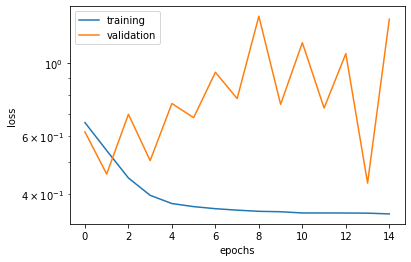

100000/100000 [==============================] - 3s 33us/sample - loss: 1.3684
1.3684136158275604


In [40]:
plt.figure()                    
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()

ev = model.evaluate(X_test, Y_test)
print(ev)

Prédictions pour le dataset avec les multiples

In [85]:
df.index[N+1:N+51]
Y_test

100001    0.0
100002    1.0
100003    0.0
100004    1.0
100005    0.0
         ... 
199996    1.0
199997    0.0
199998    1.0
199999    0.0
200000    1.0
Name: prime, Length: 100000, dtype: float64

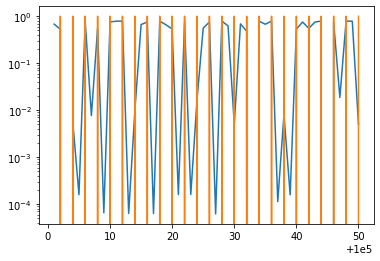

In [90]:
pred = model.predict(X_test[:50])
plt.plot(df.index[N+1:N+51], pred)
plt.plot(Y_test[:50])
plt.yscale('log')
plt.show()

Prédictions pour le dataset sans les multiples

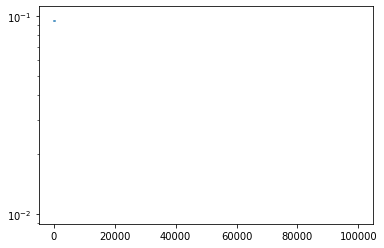

[[0.09453601 0.09453601 0.09453601 0.09453601 0.09453601 0.09453601
  0.09453601 0.09453601 0.09453601 0.09453601 0.09453601 0.09453601
  0.09453601 0.09453601 0.09453601 0.09453601 0.09453601 0.09453601
  0.09453601 0.09453601]]


In [101]:
pred = model.predict(X_test[:200])
plt.plot(pred)
plt.plot(Y_test)
plt.yscale('log')
plt.show()
print(pred[:20].T)

## Résultats

Comme on peut le voir sur les graphiques ci-dessus, le modèle sans les multiples est incapable de faire une quelquonce prédiction, tous les nombres ont la même probabilité d'être premier. 

Tandis que pour le dataset avec les multiples nous obtenons déjà des résultats plus interessant. 
On peut voir que certains point correspondent et qu'ils ont donc bien été prédit.

Toutefois il reste encore des erreurs et pour cela il faut pouvoirs essayer d'autres méthodes, on va donc essayer avec un dataset en binaire pour voir quel impact cela va avoir sur les prédictions du modèle. 